# Safe Driver prediction
In this competition, you’re challenged to build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year

By 
- James Dietle @jamesdietle
- Devan Govender @dgovender

Source:
https://github.com/jamesdietle/PortoDriver

Referances:
- Who we are borrowing from Jeremy Howard's Rossman
- https://www.kaggle.com/c/porto-seguro-safe-driver-prediction

## Next Steps
1. Implement predictions on the test set.
2. Validate accuracy

# 1. Dependencies
Things that we need to function or that are just nice
    
    - import functions 
    - correct paths and folders
    - cell noises

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Gives times for each block 
get_ipython().magic('load_ext cellevents')

# Set up paths on computer
path = '/home/jd/data/PortoDriver/'

## Import up sound alert dependencies; I really like sounds
from IPython.display import Audio, display

def allDone():
    #display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
    display(Audio(url='http://starmen.net/mother2/soundfx/eb_win.wav', autoplay=True))
    
def RunningEpochs():
    #display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
    display(Audio(url='http://starmen.net/mother2/soundfx/enterbattle.wav', autoplay=True))

In [3]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.structured import *
from fastai.dataset import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
import operator


time: 629 ms


# 2. Functions
Functions being run by the program

In [4]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

time: 2.3 ms


In [5]:
# Borrowed from 
# http://www.pythonexample.com/code/gini%20coefficient%20metric/
def gini_normalized(y_pred, targ):
  return gini(y_pred, targ) / gini(y_pred, y_pred)

def gini(actual, pred, cmpcol = 0, sortcol = 1):
  assert( len(actual) == len(pred) )
  all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
  all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
  totalLosses = all[:,0].sum()
  giniSum = all[:,0].cumsum().sum() / totalLosses
  giniSum -= (len(actual) + 1) / 2.
  return giniSum / len(actual)

time: 7.38 ms


In [6]:
#
from sklearn.metrics import roc_auc_score

inv_log = lambda x : np.exp(x)

def gini_metric(preds, targs):
    preds = inv_log(preds)
    auc = roc_auc_score(y_true=targs, y_score=preds)
    return 2 * auc - 1

time: 2.88 ms


# 3. Load in data
Loads the data we are working with into the program
- Data set provided
- Other unique datasets that would help

We are training to target

In [7]:
samplesub = pd.read_csv(f'{path}sample_submission.csv', low_memory=False)
test = pd.read_csv(f'{path}test.csv', low_memory=False)
train = pd.read_csv(f'{path}train.csv', low_memory=False)

time: 7.33 s


In [8]:
# Sample size to speed everything up
size = 3000
#test = test[:size]
#train = train [:size]

time: 896 µs


In [9]:
samplesub[:5]

,id,target
0,0,0.0364
1,1,0.0364
2,2,0.0364
3,3,0.0364
4,4,0.0364


time: 5.7 ms


In [10]:
test[:5].columns

Index(['id', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtyp

time: 2.18 ms


# 4. Manipulate Data
Prepares the data for training, determines features
- Cuts into sets
- Determines features
- Augments data
	1. More data
	2. Data augmentation
	3. Generalize wel with architectures
	4. Add regularization
    5. Reduce architecture complexity

# 5. Prepare Model
Sets up the model
    - choose optimizer
    - choose format
    - choose loss function

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

In [11]:
## Move training set over
joined = train

time: 647 µs


In [12]:
# Adding the validation set to the training set
#joined=joined.append(test)

time: 1.15 ms


In [13]:
## Just changed all of this no idea if it helps
## This works, but appears to break later
#joined=joined.replace(-1, np.NaN)

##
#joined=joined.fillna(0)

time: 877 µs


In [14]:
# Should this be changed?
joined.target=joined.target.replace(0, .0001)
joined.target=joined.target.replace(1, .9999)

time: 61.9 ms


In [15]:
#joined= joined.set_index('id')

time: 531 µs


In [16]:
joined[:5]

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0.0001,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0.0001,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0.0001,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0.0001,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0.0001,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


time: 14.8 ms


In [17]:
joined.to_feather(f'{path}joined')

time: 438 ms


## Create Features

In [18]:
joined = pd.read_feather(f'{path}joined')

time: 61.8 ms


In [19]:
joined[:5]

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0.0001,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0.0001,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0.0001,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0.0001,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0.0001,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


time: 232 ms


In [20]:
cat_vars = [
    #'id', 
    'ps_ind_02_cat', 
       'ps_ind_04_cat', 'ps_ind_05_cat','ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat',
        'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
    'ps_calc_19_bin', 'ps_calc_20_bin']

contin_vars = ['ps_car_11', 'ps_car_12', 'ps_car_13','ps_ind_14', 'ps_ind_15','ps_ind_01','ps_ind_03','ps_reg_01','ps_reg_02', 'ps_reg_03', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14']

n = len(joined); n

595212

time: 6.57 ms


In [21]:
type(cat_vars)

list

time: 1.44 ms


In [22]:
joined[:5]

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0.0001,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0.0001,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0.0001,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0.0001,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0.0001,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


time: 12.8 ms


In [23]:
samp_size = n
joined_samp = joined

time: 773 µs


In [24]:
joined

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0.0001,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0.0001,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0.0001,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0.0001,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0.0001,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0
5,19,0.0001,5,1,4,0,0,0,0,0,...,4,2,0,9,0,1,0,1,1,1
6,20,0.0001,2,1,3,1,0,0,1,0,...,3,0,0,10,0,1,0,0,1,0
7,22,0.0001,5,1,4,0,0,1,0,0,...,7,1,3,6,1,0,1,0,1,0
8,26,0.0001,5,1,3,1,0,0,0,1,...,4,2,1,5,0,1,0,0,0,1
9,28,0.9999,1,1,2,0,0,0,1,0,...,3,5,0,6,0,1,0,0,1,0


time: 109 ms


In [25]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()
for v in contin_vars: joined[v] = joined[v].astype('float32')
dep = 'target'
#joined = joined[cat_vars+contin_vars+[dep,'id']]
joined = joined[cat_vars+contin_vars+[dep,'id']]

time: 1.19 s


In [26]:
joined_samp = joined.set_index('id')
#??joined.set_index

time: 19.7 ms


In [27]:
df, y, nas, mapper = proc_df(joined_samp, 'target', do_scale=True)
yl = y
yl

array([ 0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.9999,  0.0001,
        0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.9999, ...,  0.0001,  0.0001,
        0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,
        0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001])

time: 3.61 s


In [28]:
df[:5]

,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,...,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
id,,,,,,,,,,,,,,,,,,,,,
7,3,3,2,1,2,1,1,1,1,1,...,-0.780567,1.731647,-1.417981,0.530322,-1.073849,-1.182124,1.525425,-0.367359,1.255373,0.167831
9,2,2,2,1,1,2,1,1,1,1,...,-0.780567,0.982196,1.409748,-0.839850,-1.073849,-0.493559,-1.046515,-0.367359,-1.104669,0.531911
13,5,3,2,1,1,2,1,1,1,1,...,0.100547,0.982196,-1.417981,-0.839850,-0.271891,-0.493559,-0.617858,0.463923,2.435393,-0.196249
16,2,2,2,2,1,1,1,1,1,1,...,1.862777,-0.516705,-1.417981,-0.839850,1.332025,-2.214970,-1.475171,0.463923,0.665362,0.531911
17,3,3,2,2,1,1,1,1,1,1,...,0.100547,-1.266155,-0.004117,0.530322,-0.271891,1.227851,-1.046515,-0.367359,-1.104669,-1.652569


time: 14.1 ms


In [29]:
y[:5]

array([ 0.0001,  0.0001,  0.0001,  0.0001,  0.0001])

time: 1.66 ms


In [30]:
nas

{}

time: 1.36 ms


In [31]:
mapper

DataFrameMapper(default=False, df_out=False,
        features=[(['ps_car_11'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['ps_car_12'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['ps_car_13'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['ps_ind_14'], StandardScaler(copy=True, with_mean=True, with_st...n=True, with_std=True)), (['ps_calc_14'], StandardScaler(copy=True, with_mean=True, with_std=True))],
        input_df=False, sparse=False)

time: 2.63 ms


In [32]:
len(joined)

595212

time: 1.54 ms


In [33]:
df.index[50]

125

time: 1.62 ms


In [34]:
# makes a 20% validation size
val_idx_list=train['id'].tolist()
len(val_idx_list)
val_idx = random.sample(val_idx_list, int(len(val_idx_list)*.2))
len(val_idx_list), len(val_idx)

(595212, 119042)

time: 112 ms


In [35]:
val_idx.sort()

time: 46.6 ms


In [36]:
## Get the index for something inside the list
val_target=train.target[train['id'].isin(val_idx)].tolist()
val_idx=train.index[train['id'].isin(val_idx)].tolist()
len(val_idx), len(val_target)

(119042, 119042)

time: 70.1 ms


# 6. Runs the training
Run it the training! Save the weights! 
- Make the predictions


In [37]:
max_log_y = np.max(yl)

# 1.2 doesn't make sense
#y_range = (0, max_log_y*1.2)
#y_range = (0, max_log_y*1)
y_range = (0, 1)

time: 2.02 ms


In [38]:
max_log_y,y_range

(0.99990000000000001, (0, 1))

time: 1.5 ms


In [39]:
type(cat_vars),cat_vars[:5]

(list,
 ['ps_ind_02_cat',
  'ps_ind_04_cat',
  'ps_ind_05_cat',
  'ps_ind_06_bin',
  'ps_ind_07_bin'])

time: 1.68 ms


In [40]:
yl

array([ 0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.9999,  0.0001,
        0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.9999, ...,  0.0001,  0.0001,
        0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,
        0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001])

time: 1.9 ms


In [41]:
md = ColumnarModelData.from_data_frame(path, val_idx, df, yl, cat_flds=cat_vars, bs=512)

time: 653 ms


In [42]:
#cat_sz = {c: len(joined_samp[c].cat.categories)+1 for c in cat_vars}
cat_sz = {c: len(joined[c].cat.categories)+1 for c in cat_vars}
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz.items()]

time: 2.89 ms


In [43]:
joined.target.max(),joined.target.min()

(0.99990000000000001, 0.0001)

time: 6.7 ms


In [44]:
joined.dtypes[:5]

ps_ind_02_cat    category
ps_ind_04_cat    category
ps_ind_05_cat    category
ps_ind_06_bin    category
ps_ind_07_bin    category
dtype: object

time: 2.55 ms


In [45]:
type(emb_szs)

list

time: 1.38 ms


In [46]:
emb_szs=torch.cuda.LongTensor(emb_szs)

time: 3min 5s


#torch.cuda.FloatTensor(y_range)
CudaMSECriterion_updateOutput received an invalid combination of arguments - 

got 
(int, torch.cuda.FloatTensor, !torch.cuda.LongTensor!, torch.cuda.FloatTensor, bool)
expected 

(int state, torch.cuda.FloatTensor input, torch.cuda.FloatTensor target, 
 torch.cuda.FloatTensor output, bool sizeAverage)

In [47]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   #0.04, 1, [1000,500], [0.001,0.01], y_range=None)#y_range)
                   # Has to be between 0, 1
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

time: 41.8 ms


In [48]:
RunningEpochs()

time: 3 ms


In [49]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.03756  0.03676]                                  

time: 12.4 s


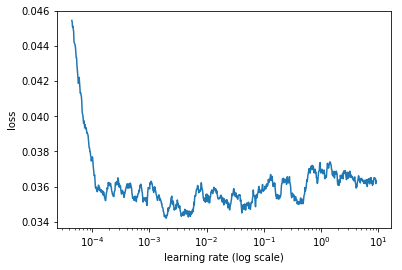

time: 379 ms


In [50]:
m.sched.plot(100)

In [51]:
lr = 1e-3

time: 675 µs


In [52]:
m.fit(lrs=lr, n_cycle=3, cycle_len=3, metrics=[accuracy, gini_normalized])

HBox(children=(IntProgress(value=0, description='Epoch', max=9), HTML(value='')))

[ 0.       0.03258  0.03517  0.       0.03091]                
[ 1.       0.0329   0.0351   0.       0.03555]                
[ 2.       0.03448  0.0351   0.       0.03681]                
[ 3.       0.03257  0.03525  0.       0.04063]                
[ 4.       0.03487  0.03514  0.       0.03803]                
[ 5.       0.03646  0.03519  0.       0.03547]                
[ 6.       0.03406  0.03517  0.       0.03609]                
[ 7.       0.03322  0.03537  0.       0.03329]                
[ 8.       0.03307  0.03552  0.       0.03312]                

time: 1min 42s


## Predictions

In [53]:
predictions=m.predict()

time: 1.13 s


In [54]:
len(predictions)

119042

time: 1.68 ms


#create ColumnarDataSet from DataFrame (df)
#cds = ColumnarDataset.from_data_frame(path, val_idx, joined, yl, cat_flds=cat_vars, bs=512)
??ColumnarDataset.from_data_frame
cds = ColumnarDataset.from_data_frame(joined, cat_flds=cat_vars, y=yl)

#create DataLoader from ColumnarDataSet
dl = DataLoader(cds)

#make predictions for DataLoader
predictions = m.predict_dl(dl)

# 7. Analyze Results
Are they what are expected? 
- Graph the results
- What are the most important features
- What do tough predictions look like? Easy predictions?

In [55]:
predictions.max(), predictions.min()

(0.92668885, 0.00035756343)

time: 1.76 ms


In [56]:
# Clips them down to something more reasonable
predictions[predictions > .999] = .999
predictions[predictions < .0001] = .0001

time: 1.13 ms


In [59]:
allDone()

time: 1.41 ms


In [60]:
predictions=m.predict()

time: 1.12 s


In [61]:
predictions=predictions.tolist()

time: 70.1 ms


In [62]:
predictions = [item[0] for item in predictions]

time: 6.39 ms


In [63]:
# If nothing changes these should all be the same number
len(val_idx), len(predictions), len(val_target)

(list, 119042, 119042, 119042)

time: 1.77 ms


In [93]:
## Validation set predicted target... I see I am very far off.
submission = pd.DataFrame({'id': val_idx, 'pred_target': predictions, 'target': val_target})

time: 26.9 ms


In [89]:
# Grab 5 largest
submission.nlargest(5, 'pred_target')

,id,pred_target,target
88146,440403,0.926689,0.9999
42470,212221,0.880346,0.0001
77983,389527,0.825377,0.0001
54820,273720,0.823889,0.9999
41464,207300,0.804985,0.0001


time: 8.38 ms


In [90]:
#Grab the 5 smallest 
submission.nsmallest(5, 'pred_target')

,id,pred_target,target
69150,346121,0.000358,0.9999
85519,427148,0.000501,0.0001
65210,326411,0.001202,0.0001
93285,465976,0.001222,0.0001
116533,582560,0.001227,0.0001


time: 7.34 ms


In [91]:
## Looks at the ones equal to target 1; These should be high
submission.loc[submission['target'] == .9999][:5]

,id,pred_target,target
1,9,0.021382,0.9999
2,19,0.011922,0.9999
15,87,0.016329,0.9999
55,249,0.059540,0.9999
63,297,0.044034,0.9999


time: 5.61 ms


In [92]:
## Looks at the ones equal to target 0; These should be low
submission.loc[submission['target'] == 0.0001][:5]

,id,pred_target,target
0,4,0.028980,0.0001
3,20,0.023059,0.0001
4,23,0.012062,0.0001
5,27,0.018962,0.0001
6,33,0.030888,0.0001


time: 6.95 ms


# 8. Submit!
- Get it put into a submitable template
- Save results

In [67]:
## Sets up the 
submission = pd.DataFrame({'id': val_idx, 'target': predictions})
# Shows 5 to ensure formatting is correct
submission[:5]

,id,target
0,4,0.028980
1,9,0.021382
2,19,0.011922
3,20,0.023059
4,23,0.012062


time: 24.6 ms


In [68]:
# Makes the submission name out of folders
path2 = path +'submits/'
## labels submissions in order
numFiles=len(os.listdir(path2))
subm_name = 'submission'+str(numFiles)+'.csv.gz'

time: 1.49 ms


In [69]:
## prints it out to downloaded
submission.to_csv((path2+subm_name), index=False, compression='gzip')
print ('http://localhost:8888/view/data/PortoDriver/submits/'+subm_name)

http://localhost:8888/view/data/PortoDriver/submits/submission5.csv.gz
time: 817 ms
